## Show Example First Level Model

This notebook gives an example of a first level model of the task switching data

In [1]:
%matplotlib inline
import os
from subprocess import call
from io import BytesIO

import pickle
import os
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats import design_matrix as dm
from nistats.reporting import plot_design_matrix
from nistats.thresholding import map_threshold
from bids.layout import BIDSLayout
from nilearn import plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as PathEffects
import seaborn as sns
import pandas as pd
import nibabel as nib
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPS

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import defaultdict, Iterator
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bo

## Setup definitions and variables

In [2]:
# https://stackoverflow.com/questions/18897511/how-to-drawimage-a-matplotlib-figure-in-a-reportlab-canvas

In [3]:
# useful function from nibetaseries 
# https://github.com/HBClab/NiBetaSeries/blob/04a679c164de1316efbac67a289a9ea33d46f64f/src/nibetaseries/interfaces/nistats.py#L278
def _select_confounds(confounds_file, selected_confounds):
    """Process and return selected confounds from the confounds file
    Parameters
    ----------
    confounds_file : str
        File that contains all usable confounds
    selected_confounds : list
        List containing all desired confounds.
        confounds can be listed as regular expressions (e.g., "motion_outlier.*")
    Returns
    -------
    desired_confounds : DataFrame
        contains all desired (processed) confounds.
    """
    import pandas as pd
    import numpy as np
    import re

    confounds_df = pd.read_csv(confounds_file, sep='\t', na_values='n/a')
    # regular expression to capture confounds specified at the command line
    confound_expr = re.compile(r"|".join(selected_confounds))
    expanded_confounds = list(filter(confound_expr.fullmatch, confounds_df.columns))
    imputables = ('framewise_displacement', 'std_dvars', 'dvars', '.*derivative1.*')

    # regular expression to capture all imputable confounds
    impute_expr = re.compile(r"|".join(imputables))
    expanded_imputables = list(filter(impute_expr.fullmatch, expanded_confounds))
    for imputable in expanded_imputables:
        vals = confounds_df[imputable].values
        if not np.isnan(vals[0]):
            continue
        # Impute the mean non-zero, non-NaN value
        confounds_df[imputable][0] = np.nanmean(vals[vals != 0])

    desired_confounds = confounds_df[expanded_confounds]
    # check to see if there are any remaining nans
    if desired_confounds.isna().values.any():
        msg = "The selected confounds contain nans: {conf}".format(conf=expanded_confounds)
        raise ValueError(msg)
    return desired_confounds

In [4]:
# convience function to save figures as eps (with transparency)
def save_eps(fig, fname):
    fig.savefig(fname + '.pdf', bbox_inches='tight')
    call(["pdf2ps", fname + '.pdf', fname + '.eps'])
    os.remove(fname + '.pdf')

In [5]:
# Hardcoded PATHS
BIDS_PATH = '../..'
FMRIPREP_PATH = '../fmriprep'
# DATABASE_PATH = '/home/jdkent/first_level.sqlite'
# DATABASE_PATH = '/home/jdkent/'
FIRST_LEVEL_RESULTS = './outputs/first_level_res.pkl'
SECOND_LEVEL_RESULTS = './outputs/second_level_res.pkl'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# OUTPUTS
ATLAS_PATH = '../data/overall_response_atlas.nii.gz'
ATLAS_LUT = '../data/overall_response.tsv'

In [6]:
# layout to get the necessary data files
layout = BIDSLayout(BIDS_PATH,
                    derivatives=FMRIPREP_PATH,
                    # database_path=DATABASE_PATH,
                    #reset_database=False
)

## Filter data based on Framewise Displacement

In [7]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

bids_name       aor       aqi  dummy_trs  \
0    sub-GE120001_ses-pre_task-fauxbold_bold  0.001063  0.006351          2   
3  sub-GE120001_ses-pre_task-taskswitch_bold  0.003942  0.005572          2   
4    sub-GE120002_ses-pre_task-fauxbold_bold  0.002056  0.010868          1   
7  sub-GE120002_ses-pre_task-taskswitch_bold  0.002134  0.004827          1   
8    sub-GE120003_ses-pre_task-fauxbold_bold  0.003094  0.018135          1   

   dvars_nstd  dvars_std  dvars_vstd       efc        fber   fd_mean  ...  \
0   16.187316   1.198663    1.010760  0.448331  3009467.75  0.103818  ...   
3   15.734272   1.148948    0.957532  0.450887  1364181.25  0.138379  ...   
4   17.975215   1.024274    1.143355  0.432753  3026978.75  0.227028  ...   
7   16.918552   1.176876    0.990735  0.431836  4213331.00  0.169619  ...   
8   38.223070   1.116687    0.909317  0.393451  2381240.50  0.577373  ...   

   summary_fg_mad  summary_fg_mean  summary_fg_median  summary_fg_n  \
0      232.520432      1381.902222        1410.488159       29195.0   
3      216.930939      1391.725708        1421.432861       29084.0   
4      225.343140      1283.572998        1322.169800       27338.0   
7      229.552505      1292.104004        1334.634033       27340.0   
8      246.342178      1247.227295        1309.490601       23125.0   

   summary_fg_p05  summary_fg_p95  summary_fg_stdv       tsnr        task  \
0      837.753119     1812.366785       297.530945  64.075073    fauxbold   
3      868.629898     1788.999225       284.924835  72.902779  taskswitch   
4      738.498715     1686.504254       287.157501  47.578674    fauxbold   
7      734.595834     1700.930396       292.718201  71.898445  taskswitch   
8      595.968738     1648.415723       314.057434  31.255548    fauxbold   

   participant_id  
0        GE120001  
3        GE120001  
4        GE120002  
7        GE120002  
8        GE120003  

[5 rows x 47 columns]

In [8]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

In [9]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [10]:
ent = layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

## Run model on all data

In [11]:
def _merge_masks(masks):
    mask_img = nib.load(masks.pop(0))
    add_mask = mask_img.get_fdata().astype(int)
    for counter, mask in enumerate(masks):
        add_mask += nib.load(mask).get_fdata().astype(int)
    half_masks = counter // 2
    bin_mask = np.where(add_mask > half_masks, 1, 0)
    bin_mask_img = nib.Nifti1Image(bin_mask, mask_img.affine, header=mask_img.header)

    return bin_mask_img

In [12]:
def get_duplicate_columns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if np.all(np.isclose(col, otherCol)):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)


def _fit_first_level(layout, participant, task, confounds, mask, debug_design=False, specific_contrasts=None):
    preproc = layout.get(subject=participant,
                     suffix='bold',
                     extension='nii.gz',
                     desc='preproc',
                     space='MNI152NLin2009cAsym',
                     task=task)[0]
    preproc_file = preproc.path
    tr = preproc.get_metadata()['RepetitionTime']

    confounds_file = layout.get(subject=participant,
                            suffix='regressors',
                            extension='tsv',
                            desc='confounds',
                            task=task,
                            return_type='file')[0]
    
    event_file = layout.get(subject=participant,
                            suffix='events',
                            extension='tsv',
                            task=task,
                            return_type='file')[0]

    
    events_df = pd.read_csv(event_file, sep='\t')
    print("found files")
    confounds_df = _select_confounds(confounds_file, confounds)
    # drop duplicate columns (e.g., non_steady_state volume may be the same as motion_outlier volume)
    confounds_df.drop(columns=get_duplicate_columns(confounds_df), inplace=True)

    frame_times = np.arange(nib.load(preproc_file).shape[-1]) * tr
    # drift_model is None because I'm assuming user is passing Cosine inputs
    design_matrix = dm.make_first_level_design_matrix(
        frame_times, events_df, drift_model=None, add_regs=confounds_df,
        add_reg_names=confounds_df.columns.to_list())
    
    print("made design matrix")
    # fit the model
    model = FirstLevelModel(t_r=tr,
                            drift_model=None,
                            high_pass=None,
                            smoothing_fwhm=6.0,
                            mask_img=mask)
    
    print("made model")
    model.fit(preproc_file, design_matrices=design_matrix)
    print("fit model")
    trial_types = events_df['trial_type'].unique()
    # generate overall task contrast
    effect_of_interest = np.array([[1 if c == trial_type else 0 for c in design_matrix.columns]
                                   for trial_type in trial_types])

    contrasts = {trial_type: np.array([1 if c == trial_type else 0 for c in design_matrix.columns])
                 for trial_type in trial_types}

    contrasts['overall_resp'] = np.array([[1 if c == trial_type else 0 for c in design_matrix.columns]
                                   for trial_type in trial_types])

    if specific_contrasts:
        for contrast in specific_contrasts:
            contrasts[contrast] = contrast

    print("made contrasts")
    c_maps = {}
    for name, contrast in contrasts.items():
         c_maps[name] = model.compute_contrast(contrast, output_type='all')
    
    print("computed contrasts")

    if debug_design:
        return c_maps, design_matrix
    else:
        return c_maps

In [13]:
min_confounds = ["white_matter", "csf", "cosine[0-9]{2}", "framewise_displacement", "non_steady_state_outlier[0-9]{2}", "motion_outlier[0-9]{2}"]
task = 'taskswitch'

mask_files = layout.get(suffix='mask',
                        extension='nii.gz',
                        desc='brain',
                        space='MNI152NLin2009cAsym',
                        task=task,
                        subject=good_participants,
                        return_type='file')

mask_img = _merge_masks(mask_files)



In [14]:
plotting.view_img(mask_img, opacity=0.4)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


In [15]:
my_contrasts = ['switch - single', 'repeat - single', 'switch - repeat', '((switch + repeat)/2) - single']
if os.path.isfile(FIRST_LEVEL_RESULTS):
    with open(FIRST_LEVEL_RESULTS, "rb") as pklr:
        first_level_res = pickle.load(pklr)
else:
    first_level_res = {
        part: _fit_first_level(layout, part, task, min_confounds, mask_img, specific_contrasts=my_contrasts)
        for part in good_participants
    }
    with open(FIRST_LEVEL_RESULTS, "wb") as pklw:
        pickle.dump(first_level_res, pklw)

found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
ma

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/first_level_model.py:73: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/first_level_model.py:73: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts
found files
made design matrix
made model
fit model
made contrasts
computed contrasts


## Second Level Model

In [16]:
# number of participants
len(first_level_res.keys())

40

In [17]:
# model the intercept to get an average
snd_lvl_des_mtx = pd.DataFrame([1] * len(first_level_res.keys()), columns=['intercept'])

In [18]:
# get all contrasts
contrast_types = list(first_level_res['GE120001'].keys())

In [23]:
contrast_types

['single',
 'firsttrial',
 'switch',
 'repeat',
 'overall_resp',
 'switch - single',
 'repeat - single',
 'switch - repeat',
 '((switch + repeat)/2) - single']

In [26]:
if os.path.isfile(SECOND_LEVEL_RESULTS):
    with open(SECOND_LEVEL_RESULTS, "rb") as pklr:
        second_level_res = pickle.load(pklr)
else:
    second_level_res = {}
    for contrast in contrast_types:
        c_stats = {}
        cmap_imgs = [c[contrast]['effect_size'] for c in first_level_res.values()]
        snd_model = SecondLevelModel().fit(cmap_imgs, design_matrix=snd_lvl_des_mtx)
        c_stats['no_thresh'] = snd_model.compute_contrast(output_type='z_score')
        c_stats['fdr05_thresh'], _ = map_threshold(c_stats['no_thresh'], alpha=.05, cluster_threshold=10, height_control='fdr')
        c_stats['fdr01_thresh'], _ = map_threshold(c_stats['no_thresh'], alpha=.01, cluster_threshold=10, height_control='fdr')
        second_level_res[contrast] = c_stats

    with open(SECOND_LEVEL_RESULTS, "wb") as pklw:
        pickle.dump(second_level_res, pklw)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/image/image.py:455: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  not isinstance(imgs, collections.Iterable)):


In [27]:
for idx, (contrast, c_stats) in enumerate(second_level_res.items()):
    display(plotting.view_img(second_level_res[contrast]['fdr01_thresh'],
                              threshold=3.1, vmax=10, title=contrast))

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


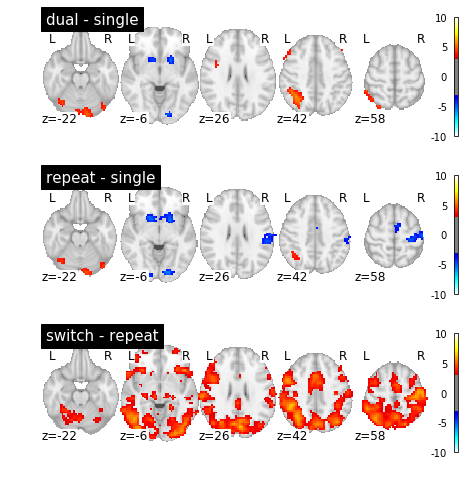

In [38]:
plot_contrasts = ['((switch + repeat)/2) - single', 'repeat - single', 'switch - repeat']
fig, axes = plt.subplots(nrows=len(plot_contrasts), figsize=(7.5, 8.25))
for ax, contrast in zip(axes, plot_contrasts):
    if contrast == '((switch + repeat)/2) - single':
        contrast_title = "dual - single"
    else:
        contrast_title = contrast
    plotting.plot_stat_map(second_level_res[contrast]['fdr01_thresh'],
                           threshold=3.1, axes=ax, vmax=10, title=contrast_title, display_mode='z',
                           cut_coords=(-22, -6, 26, 42, 58))

save_eps(fig, './outputs/contrast_summary')

## Extract regions from first level maps

In [ ]:
from nilearn.regions import RegionExtractor, connected_regions
from nilearn.image import threshold_img
from nistats.reporting import get_clusters_table

In [ ]:
# 14 mm was chosen as the minimum distance to have non-overlapping regions of interest
# a slightly higher threshold (3.3 versus 3.1) breaks up the large clusters into smaller reportable clusters
if not os.path.isfile("./outputs/cluster_table.tsv"):
    overall_resp_clusters = get_clusters_table(second_level_res['overall_resp']['no_thresh'],
                       stat_threshold=3.3,
                       cluster_threshold=10,
                       min_distance=14)

    overall_resp_clusters.to_csv("./outputs/cluster_table.tsv",
                                 sep='\t',
                                 index=False,
                                 float_format='%.2f',
                                 na_rep="sub-cluster")
else:
    overall_resp_clusters = pd.read_csv("outputs/cluster_table.tsv", sep='\t')

overall_resp_clusters

In [ ]:
# create look up table
lut_df = pd.DataFrame.from_dict(
    {"regions": overall_resp_clusters['Cluster ID'].astype(str),
     "index": np.array(overall_resp_clusters.index + 1)}
)
lut_df.head()
lut_df.to_csv(ATLAS_LUT, index=False, sep='\t')

In [ ]:
coords = overall_resp_clusters[["X", "Y", "Z"]].values

In [ ]:
clusters = overall_resp_clusters['Cluster ID'].astype(str).str.replace(r'([0-9])[a-z]{0,1}', r'\1').astype(int)
uniq_clusters = clusters.unique()
min_clust = uniq_clusters.min()
max_clust = uniq_clusters.max()
norm = matplotlib.colors.Normalize(vmin=min_clust, vmax=max_clust)
cmap = matplotlib.cm.get_cmap('Spectral')
colors = cmap(norm(clusters.values))

In [ ]:
coords

In [ ]:
from nilearn import plotting  
view = plotting.view_markers(
      coords, marker_size=10, colors=colors) 
view

In [ ]:
# adapted from https://github.com/nilearn/nilearn/blob/bfbc2632f90e7e8e3ee3b7036d4fd08d8ec91fec/nilearn/input_data/nifti_spheres_masker.py#L23

import numpy as np
from sklearn import neighbors
# from nilearn._utils.compat import Memory

from nilearn.image.resampling import coord_transform
# from .._utils.niimg_conversions import _safe_get_data
# from .._utils import CacheMixin
# from .._utils.niimg import img_data_dtype
from nilearn._utils.niimg_conversions import check_niimg_3d
# from .._utils.class_inspect import get_params
# from .. import image
from nilearn import masking
# from .base_masker import filter_and_extract, BaseMasker

def _apply_mask_and_get_affinity(seeds, radius, allow_overlap,
                                 mask_img):
    seeds = list(seeds)
    affine = mask_img.affine

    # Compute world coordinates of all in-mask voxels.
    mask_img = check_niimg_3d(mask_img)
    mask, _ = masking._load_mask_img(mask_img)
    mask_coords = list(zip(*np.where(mask != 0)))

    # For each seed, get coordinates of nearest voxel
    nearests = []
    for sx, sy, sz in seeds:
        nearest = np.round(coord_transform(sx, sy, sz, np.linalg.inv(affine)))
        nearest = nearest.astype(int)
        nearest = (nearest[0], nearest[1], nearest[2])
        try:
            nearests.append(mask_coords.index(nearest))
        except ValueError:
            nearests.append(None)

    mask_coords = np.asarray(list(zip(*mask_coords)))
    mask_coords = coord_transform(mask_coords[0], mask_coords[1],
                                  mask_coords[2], affine)
    mask_coords = np.asarray(mask_coords).T

    clf = neighbors.NearestNeighbors(radius=radius)
    A = clf.fit(mask_coords).radius_neighbors_graph(seeds)
    A = A.tolil()
    for i, nearest in enumerate(nearests):
        if nearest is None:
            continue
        A[i, nearest] = True

    # Include the voxel containing the seed itself if not masked
    mask_coords = mask_coords.astype(int).tolist()
    for i, seed in enumerate(seeds):
        try:
            A[i, mask_coords.index(seed)] = True
        except ValueError:
            # seed is not in the mask
            pass

    if not allow_overlap:
        if np.any(A.sum(axis=0) >= 2):
            raise ValueError('Overlap detected between spheres')
    
    # numpy array format is more familiar to me
    rois = A.asformat("array")
    

    # range of values the rois can take (to make sure they are all unique)
    roi_idx = np.arange(1, rois.shape[0] + 1)
    
    # make each roi have its own unique value
    roi_matrix = (rois.T * roi_idx).sum(axis=1)
    
    # import pdb; pdb.set_trace()
    # place the rois in "brain space"
    roi_data = mask_img.get_fdata().copy()
    roi_data[mask_img.get_fdata().astype(bool)] = roi_matrix
    roi_img = nib.Nifti1Image(roi_data, mask_img.affine, header=mask_img.header)

    return roi_img

In [ ]:
roi_img = _apply_mask_and_get_affinity(seeds=coords, radius=5, allow_overlap=False, mask_img=mask_img)

In [ ]:
bool_roi_img = nib.Nifti1Image(roi_img.get_fdata().astype(bool), roi_img.affine, roi_img.header)

In [ ]:
plotting.view_img(roi_img, resampling_interpolation='nearest')
# z 68, 42, 36, 32, 24, 20, 8, -6, -12, -18

In [ ]:
# "#ad03de"
def add_txt(ax, region, coord_df):
    xy = coord_df[coord_df["Cluster ID"] == region][["X", "Y"]].values.flatten()
    ax.annotate(region, xy, ha='center', va='center', weight="heavy",color="black",
                size=12,
                path_effects=[PathEffects.withStroke(linewidth=3,
                                                     foreground="white")])
    return ax

In [ ]:
cmap_list = sns.xkcd_palette(["electric green"])
cmap=ListedColormap(cmap_list)

fig, axs = plt.subplots(nrows=3, figsize=(7.5, 7))

display1 = plotting.plot_stat_map(second_level_res['overall_resp']['fdr01_thresh'],
                       threshold=3.1, axes=axs[0], figure=fig, vmax=10,  display_mode='z',
                       cut_coords=(68, 42, 32), colorbar=False)

display2 = plotting.plot_stat_map(second_level_res['overall_resp']['fdr01_thresh'],
                       threshold=3.1, axes=axs[1], figure=fig, vmax=10, display_mode='z',
                       cut_coords=(24, 20, 8), colorbar=False)

display3 = plotting.plot_stat_map(second_level_res['overall_resp']['fdr01_thresh'],
                       threshold=3.1, axes=axs[2], figure=fig, vmax=10, display_mode='z',
                       cut_coords=(-6, -12, -18, -48), colorbar=False)
# display.add_overlay(bool_roi_img, cmap=cmap, alpha=1, vmin=1, vmax=1)


# at z=-48 (1b, 1c)
add_txt(fig.axes[-1], "1b", overall_resp_clusters)
add_txt(fig.axes[-1], "1c", overall_resp_clusters)
# at z=-18 (1, 1a, 3, 3a)
add_txt(fig.axes[-2], "1", overall_resp_clusters)
add_txt(fig.axes[-2], "1a", overall_resp_clusters)
add_txt(fig.axes[-2], "3", overall_resp_clusters)
add_txt(fig.axes[-2], "3a", overall_resp_clusters)

# at z=-12 (3b)
add_txt(fig.axes[-3], "3b", overall_resp_clusters)

# at z=-6 (5)
add_txt(fig.axes[-4], "5", overall_resp_clusters)

# at z=8 (2b, 4, 4b, 4c, 6)
add_txt(fig.axes[-5], "2b", overall_resp_clusters)
add_txt(fig.axes[-5], "4", overall_resp_clusters)
add_txt(fig.axes[-5], "4b", overall_resp_clusters)
add_txt(fig.axes[-5], "4c", overall_resp_clusters)
add_txt(fig.axes[-5], "6", overall_resp_clusters)

# at z=20 (2, 4a, 7b)
add_txt(fig.axes[-6], "2", overall_resp_clusters)
add_txt(fig.axes[-6], "4a", overall_resp_clusters)
add_txt(fig.axes[-6], "7b", overall_resp_clusters)

# at z=24 (7a)
add_txt(fig.axes[-7], "7a", overall_resp_clusters)

# at z=32 (7, 8)
add_txt(fig.axes[-8], "7", overall_resp_clusters)
add_txt(fig.axes[-8], "8", overall_resp_clusters)

# at z=42 (2a)
add_txt(fig.axes[-9], "2a", overall_resp_clusters)

# at z=68 (2c)
add_txt(fig.axes[-10], "2c", overall_resp_clusters)

save_eps(fig, './outputs/stat-map-overall_resp_with_rois')
# fig.savefig('./outputs/stat-map-overall_resp_with_rois_tiff.tiff', dpi=600, bbox_inches='tight')
# fig.savefig('./outputs/stat-map-overall_resp_with_rois.pdf', bbox_inches='tight')

In [ ]:
np.unique(roi_img.get_fdata())

In [ ]:
roi_img.to_filename(ATLAS_PATH)

## Playground Area